In [ ]:
import datetime
print datetime.datetime.now()

aaa-usa


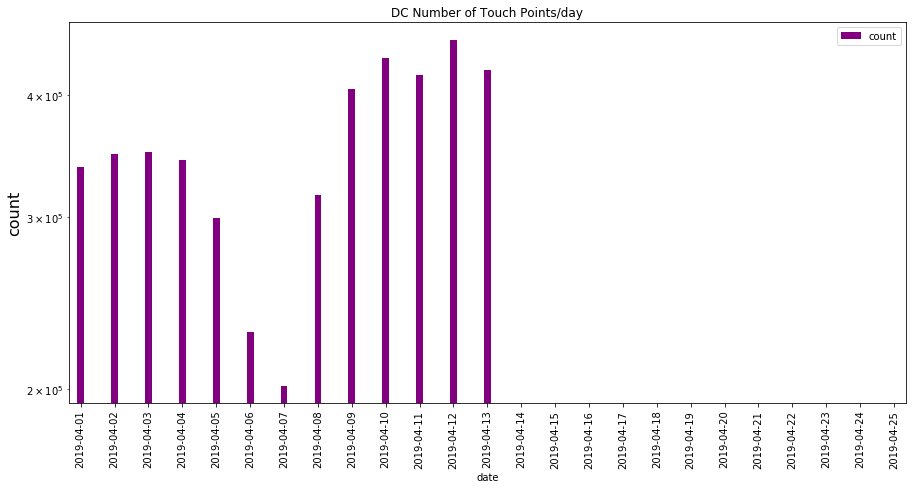

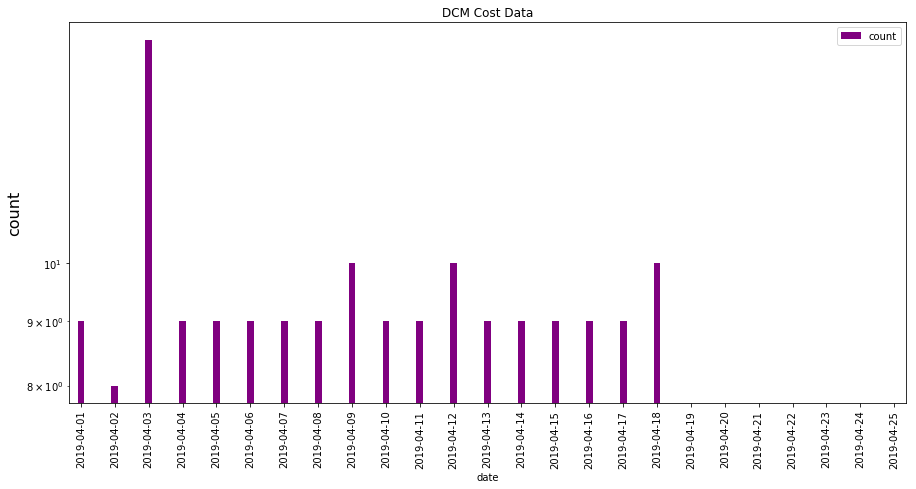

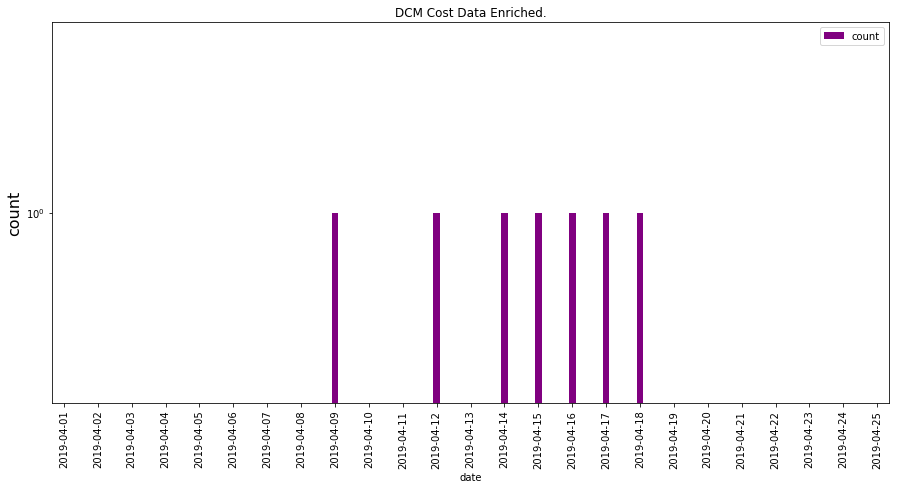

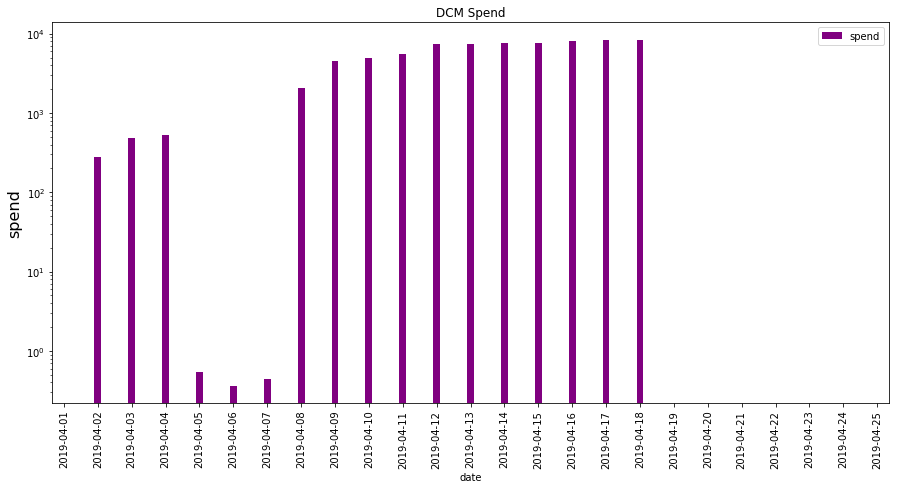

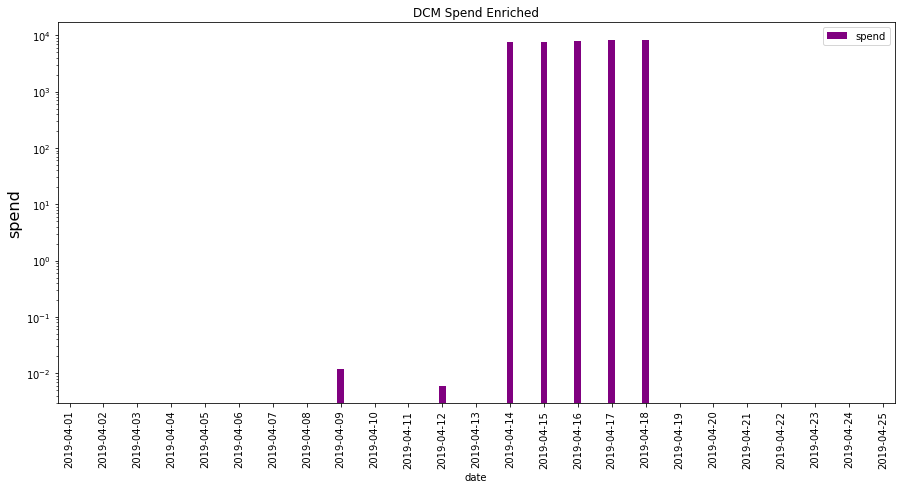

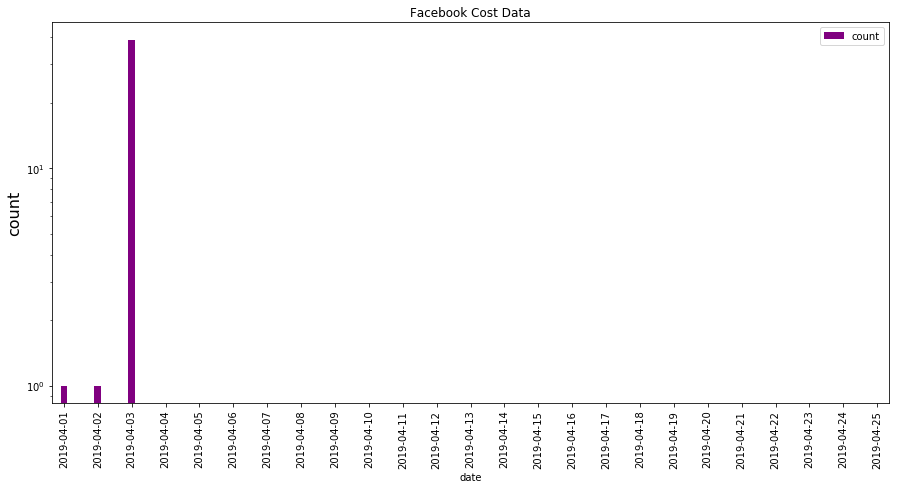

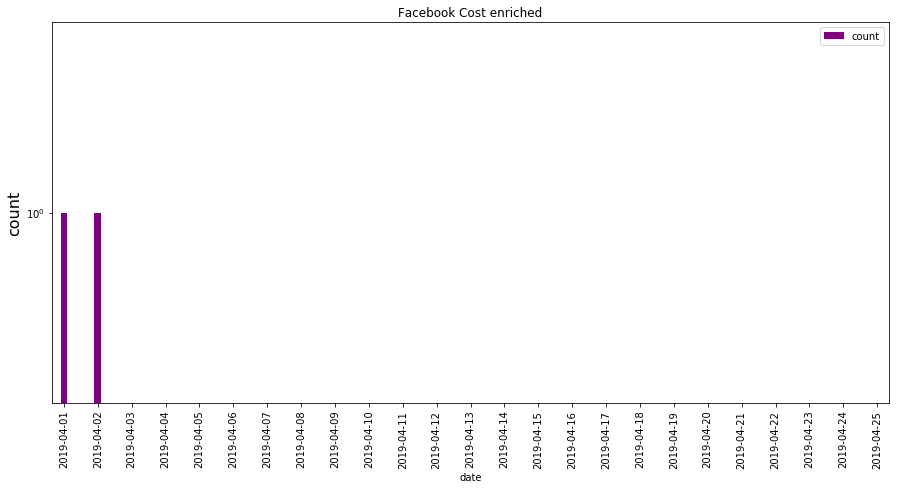

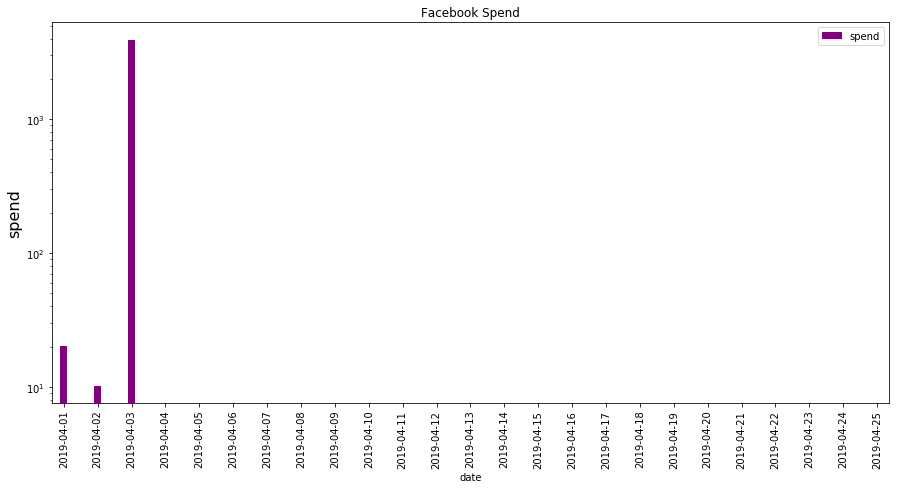

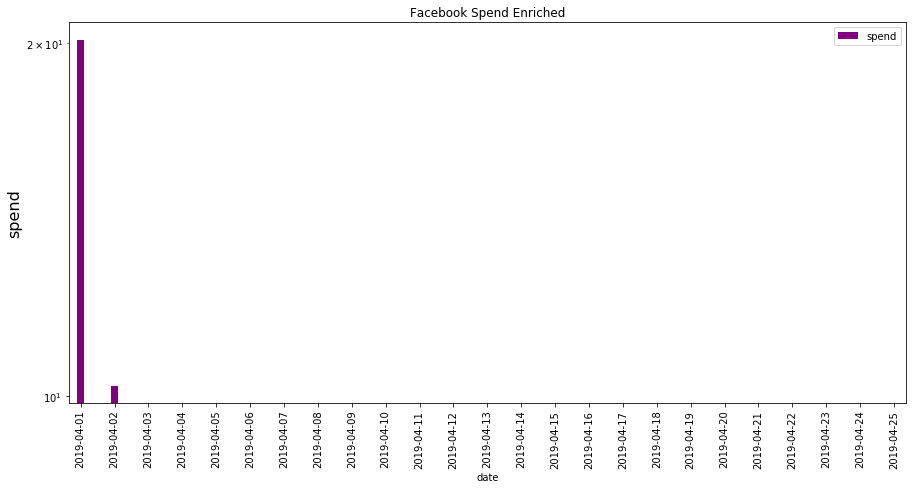

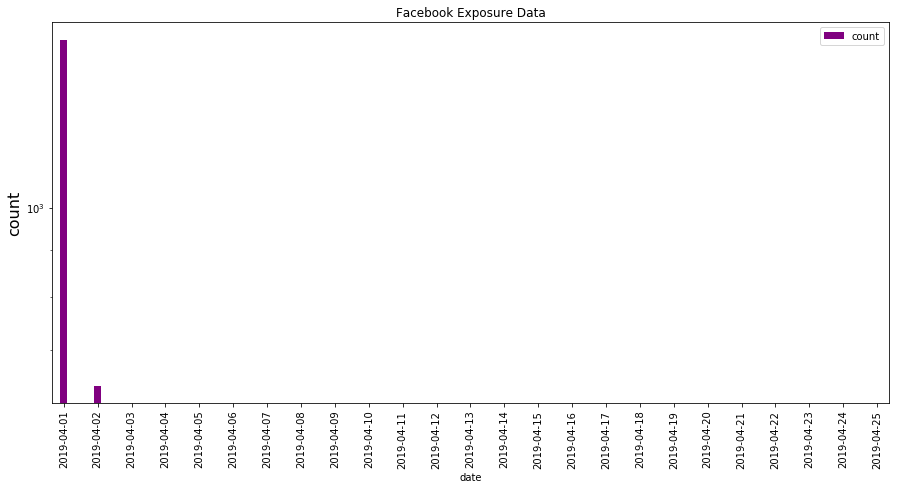

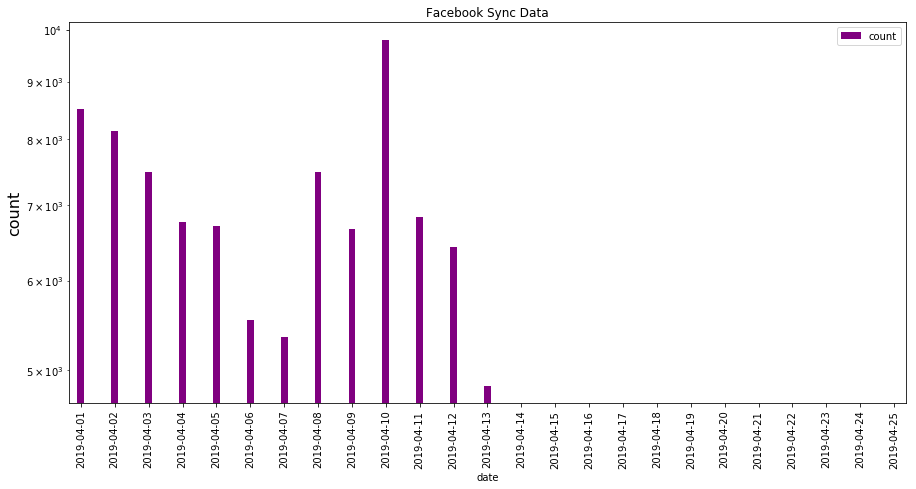

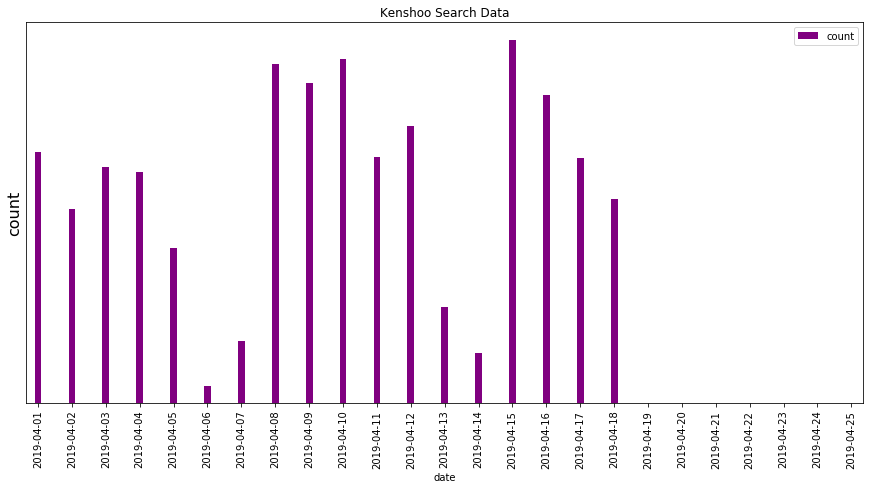

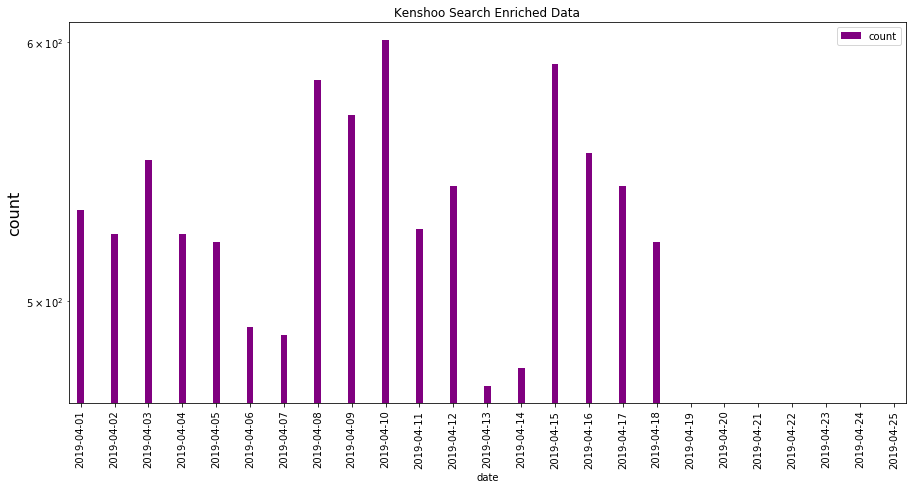

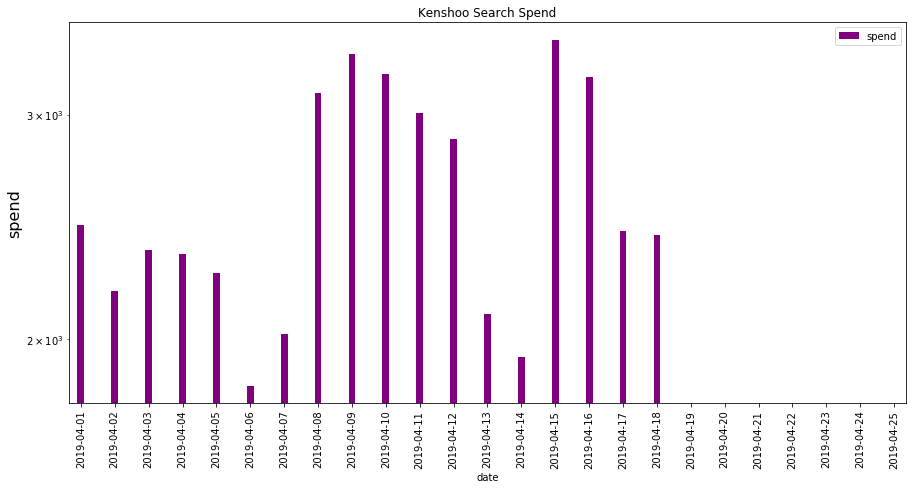

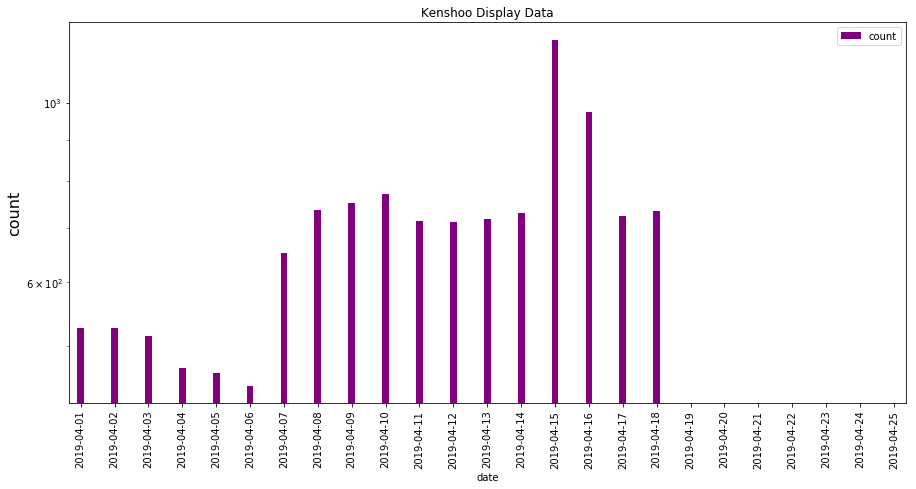

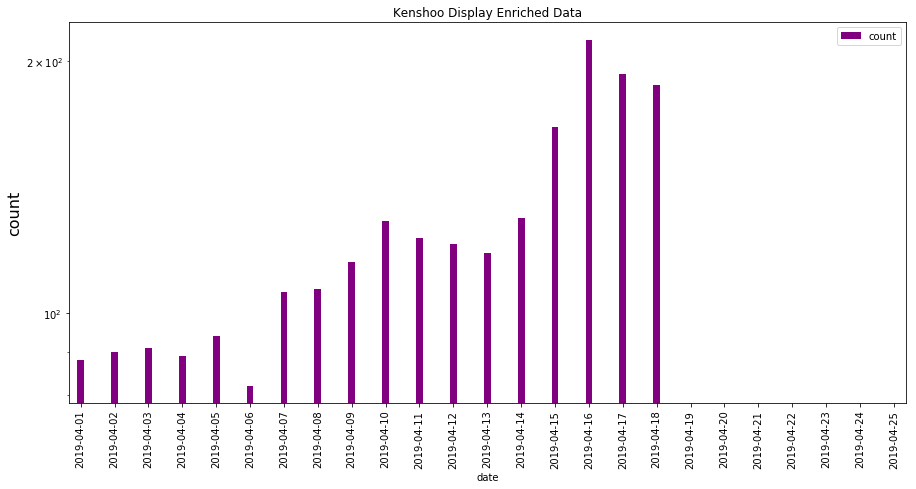

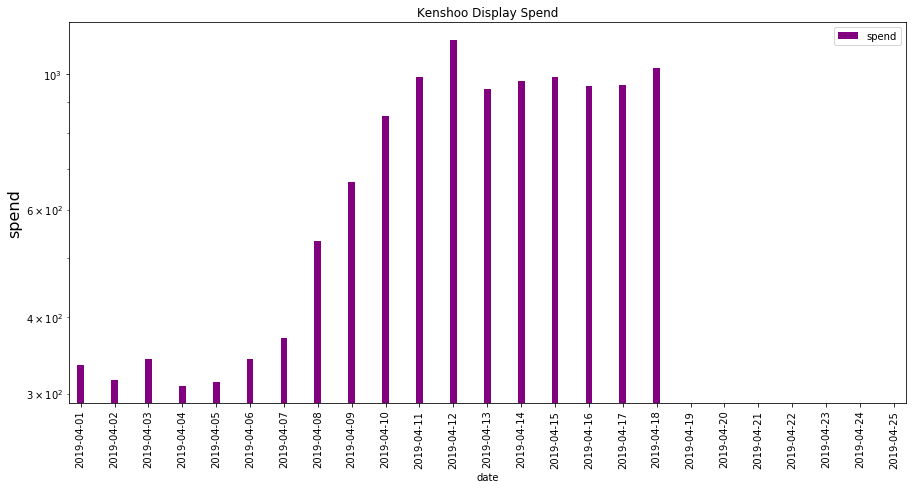

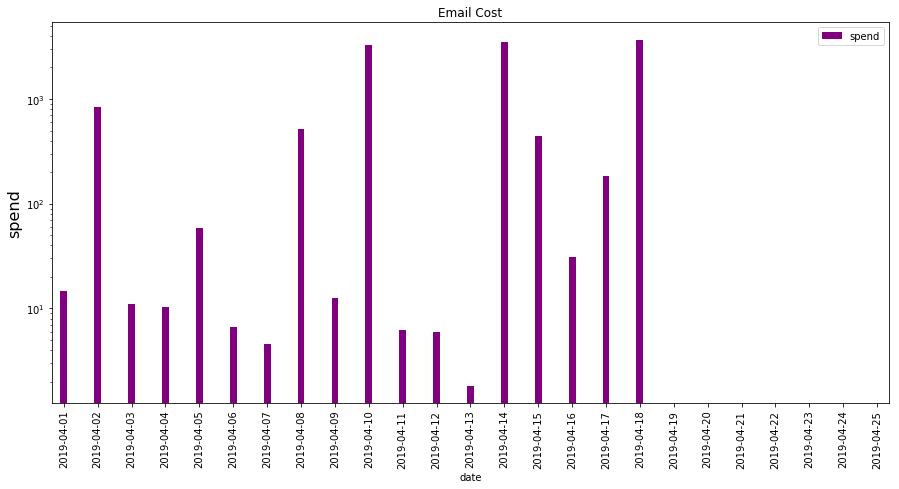

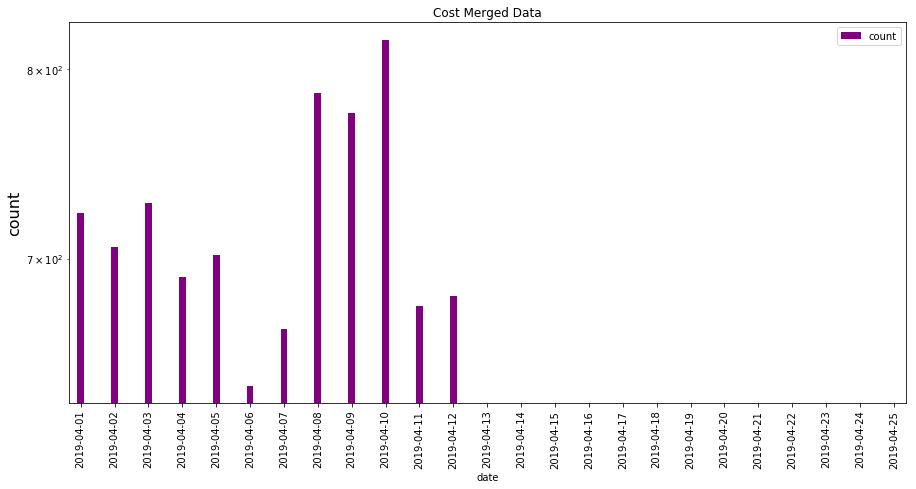

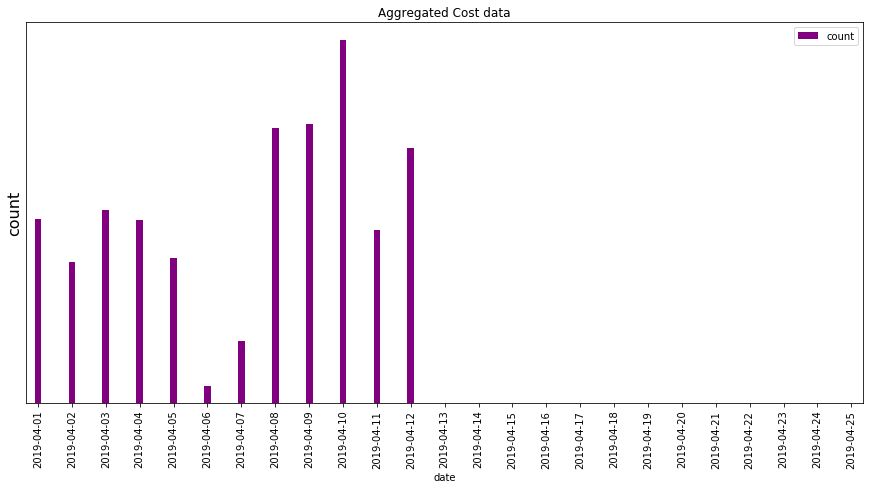

dc paths Files not present to Plot Conversions Per Day

dc paths Files not present to Plot Conversions Per Day / Channel

In dc, paths data is not present to Plot Path Length Distribution

In dc, paths data is not present to Plot Path Length Distribution / Channel



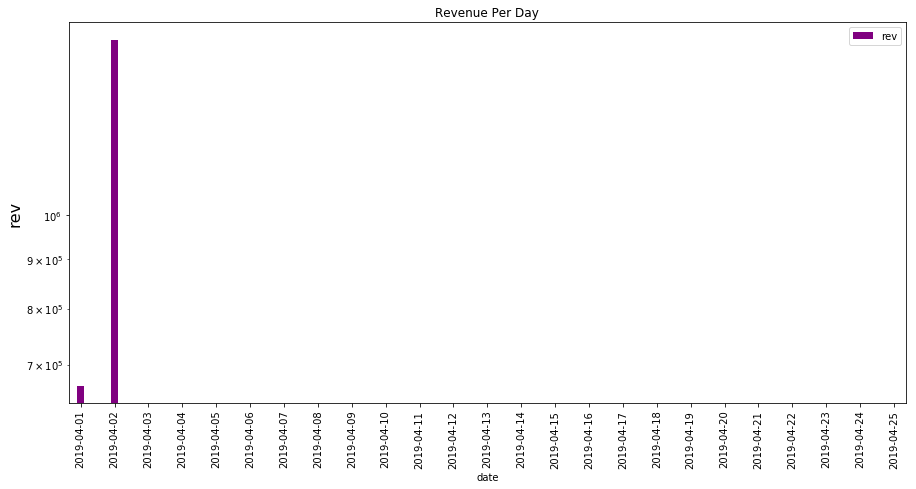

In dc, paths data is not present to Plot Null V/S Total Campaign for channel Paid Search

In dc, paths data is not present to Plot Null V/S Total Campaign for channel Paid Social

In dc, paths data is not present to Plot Null V/S Total Campaign for channel Display

In dc, paths data is not present to Plot Null V/S Total Campaign for channel Other



In [9]:

import pandas as pd
from google.cloud import bigquery as bq
import matplotlib as mp
import os
import smtplib
import csv
import sys
import datetime as dt
import sendgrid
import re
import warnings
from sendgrid.helpers.mail import *
%matplotlib inline
arg_file='inputs/.args'
warnings.filterwarnings('ignore')
Empty_Files={}
client_ids=['aaa-usa','open-colleges','dyson-205108','srprsme-192904']
def send_mail(start_date,end_date,client,message_file):
    with open (message_file,"r+") as fo:
            msg_list=fo.readlines()
    with open('inputs/key.env','r+') as fo:
            key=fo.read()
    sg = sendgrid.SendGridAPIClient(key.rstrip('\n'))
    if msg_list:
          message='Below tables are either empty or not created in GBQ for date range\
                   '+start_date+\
                   ' and '  + end_date+"\n"\
                   ' for '+client.upper()+"\n"+'\n'.join(msg_list)
    else:
          message='All files are available with data in date range '+start_date +' and '  + \
                   end_date+"\n"+' for '+client.upper()+"\n"
    data = {
        "personalizations": [
            {
            "to": [{
                    "email": "spillai@datalicious.com"
                },{"email":"kchowdhury@datalicious.com"}],
            "subject": "Missing or Empty Files"
            }
        ],
        "from": {
            "email": "noreply@optimahub.com"
        },
        "content": [
            {
            "type": "text/plain",
            "value":message
            }
        ]
        }
    sg.client.mail.send.post(request_body=data)

    
       
def Data_Plot(row,df):
    if row['plot_type']=='pie':
        ax=pd.pivot_table(df, index = 'campaign').plot(kind='pie',y='count'
                                                       ,figsize=(5,5),title=row['title'])
        ax.set_aspect('equal')
    elif row['plot_type']=='stack':
        if (df[list(df)[2]] == 0).all():
            print row['source']+" "+row['table']+" Files not present to Plot " +row['title']+"\n"
        else:
            ax=pd.pivot_table(df, index = list(df)[0], columns =list(df)[1], 
                              values =list(df)[2]).plot(kind = 'bar',title=row['Title'],
                                                        width=0.8,figsize=(15,7),stacked=True)
            ax.set_ylabel(list(df)[2],fontsize=16)
    else:
        if (df[list(df)[1]] == 0).all():
            print row['source']+" "+row['table']+" Files not present to Plot " +row['title']+"\n"
        else:
            ax=pd.pivot_table(df, index = list(df)[0],
                              values =list(df)[1]).plot(kind = 'bar',title=row['title'],
                                                        width=0.2,color='purple',figsize=(15,7))
            ax.set_yscale('log',basey=10)
            #ax.set_yticklabels(ax.get_yticks())
            ax.set_ylabel(list(df)[1],fontsize=16)
    mp.pyplot.show()
            
            
def Create_Frame(clnt,start_date,end_date,start_date_string,end_date_string):
    print clnt
    client= bq.Client.from_service_account_json('inputs/service_account.json')
    fields=[];rows=[]
    with open("inputs/query.csv","r")  as fo:
        csvreader = csv.DictReader(fo)
        for row in csvreader:
          row['query']=row['query'].format(client=clnt,start_date=start_date,end_date=end_date,
                                           start_date_string=start_date_string,end_date_string=end_date_string)
          if clnt=='srprsme-192904'and  row['source']=='bing':
                continue
          try:
            df=client.query(row['query']).to_dataframe()
            if row['metric_type']=='count': 
                missing_files=df.loc[df[row['metric_type']] == 0]['date']
                key="In " + row['source']+", "+row['table']+" "+ "table"
                Empty_Files[key]=list(missing_files)
            if df.empty:
                print "In " + row['source']+", "+row['table']+" data is not present to Plot " +row['title']+"\n"
                continue
            else:
                Data_Plot(row,df)
          except Exception as e:
            continue
    missing_files={k: v for k, v in Empty_Files.items() if v}
    return missing_files
    
    
def main():
    if os.path.isfile(arg_file):
        with open(arg_file,'r+') as fo:
            args = list(line for line in (val.rstrip() for val in fo) if line)   
        client=args[0]
        if client not in client_ids: 
            print 'Invalid client ID Provided'
            sys.exit()
        start_date=args[1] if len(args)>1 else (dt.datetime.now() 
                                                - dt.timedelta(11)).strftime('%Y-%m-%d')
        end_date=args[2] if len(args)>2  else (dt.datetime.now() 
                                               - dt.timedelta(4)).strftime('%Y-%m-%d')
        start_date_string = re.sub('-', '',start_date)
        end_date_string=re.sub('-','',end_date)        
    Empty_Files=Create_Frame(client,start_date,end_date,start_date_string,end_date_string)
    with open('message',"w+") as fo:
        for k,v in Empty_Files.items():
          fo.write(k+' for below dates '+'\n')
          for val in v:
                fo.write(str(val)+'\n')
    send_mail(start_date,end_date,client,'message')

if __name__=="__main__":
    main()